In [1]:
import os
import tensorflow as tf
import seaborn as sns
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers import Dense,Activation,Dropout,Conv2D,MaxPooling2D,BatchNormalization,Flatten
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model, load_model, Sequential
from sklearn.metrics import confusion_matrix, classification_report
# from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt
import matplotlib.image as mping
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd

In [2]:
train_dir = "AutismDataset/train"
test_dir = "AutismDataset/test"
val_dir = "AutismDataset/valid"
train_data=image_dataset_from_directory(train_dir,batch_size=64,image_size=(224,224),label_mode='categorical',shuffle=True,seed=42)
test_data=image_dataset_from_directory(test_dir,batch_size=64,image_size=(224,224),label_mode='categorical',shuffle=False,seed=42)
val_data=image_dataset_from_directory(val_dir,batch_size=64,image_size=(224,224),label_mode='categorical',shuffle=False,seed=42)

Found 2550 files belonging to 2 classes.
Found 300 files belonging to 2 classes.
Found 100 files belonging to 2 classes.


In [3]:
class_names=train_data.class_names
class_count=len(class_names)
print(class_count)

2


In [5]:
samples = []
x = 0
for i in tqdm(train_data.unbatch()):
    if (x == 10):
        break
    samples.append([i[0], i[1]])
    x += 1

0it [00:00, ?it/s]

In [6]:
images = []
labels = []
for i in samples:
    images.append(i[0])
    labels.append(class_names[tf.argmax(i[1])])
len(images), len(labels)

(10, 10)

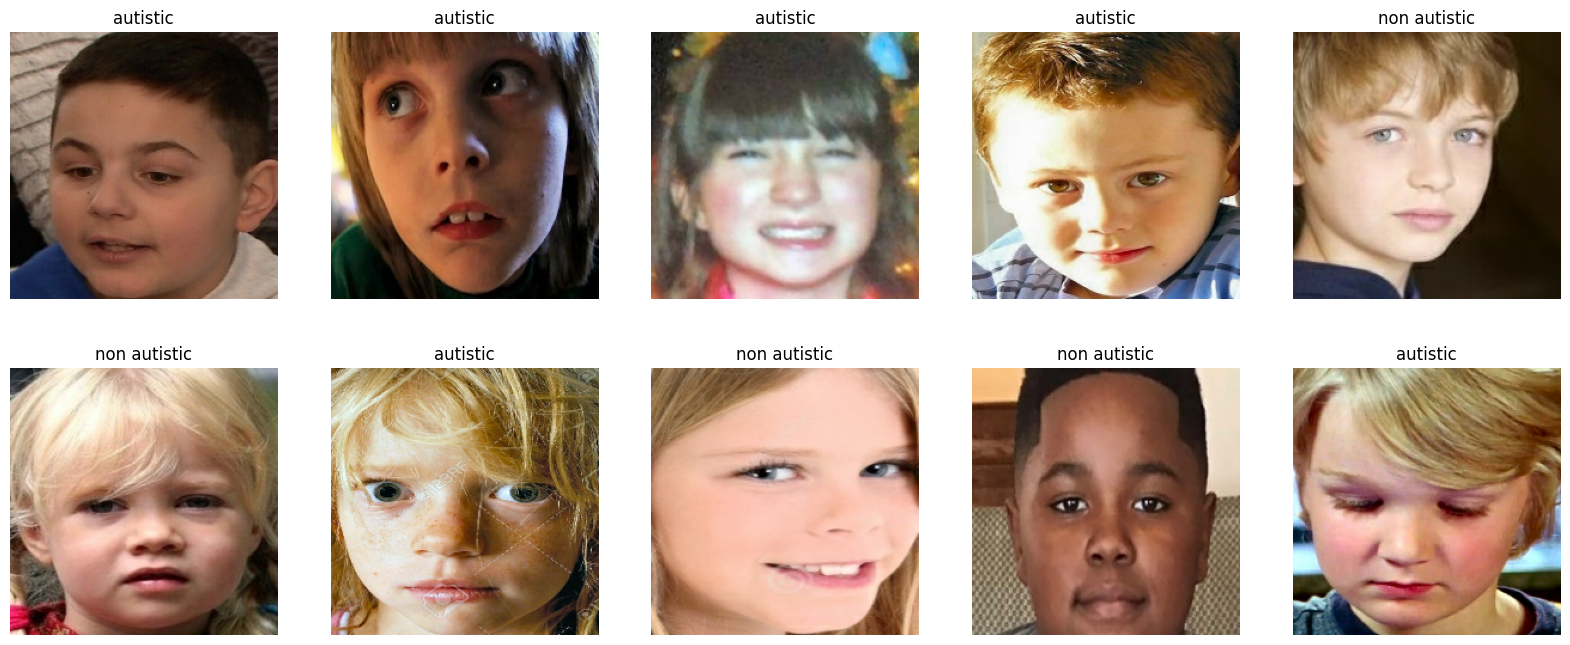

In [7]:
fig = plt.figure(figsize=(20, 8))
rows = 2
cols = 5
x = 1
for image, label in zip(images, labels):
    fig.add_subplot(rows, cols, x)
    plt.imshow(image/255.)
    plt.axis("off")
    plt.title(label)
    x += 1

In [8]:
print(train_data)

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 2), dtype=tf.float32, name=None))>


In [9]:
input_shape = (224, 224,3)

In [10]:
from keras.applications import EfficientNetB4, VGG19, NASNetMobile, Xception , EfficientNetB2,MobileNet

# Function to create a model
def create_model(model_name):
    model_name = 'MobileNet'
    base_model = tf.keras.applications.MobileNet(
    include_top=False, weights="imagenet", input_shape=input_shape, pooling='max')

    x = base_model.output
    x = BatchNormalization()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(rate=0.45, seed=42)(x)
    output = Dense(class_count, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=output)
    model.compile(tf.keras.optimizers.Adam(learning_rate=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [11]:
# Function to train and evaluate a model
def train_and_evaluate_model(model, train_data, val_data, test_data, model_name):
    early_stopper = tf.keras.callbacks.EarlyStopping(patience=5, min_delta=0.01, verbose=1)
    history = model.fit(train_data, epochs=100, validation_data=val_data, callbacks=[early_stopper])

    test_loss , test_accuracy = model.evaluate(test_data)
    print(f"Test Accuracy for {model_name}:", test_accuracy)

    test_data_array = []
    labels_array = []
    for images, labels in test_data:
        test_data_array.append(images.numpy())
        labels_array.append(labels.numpy())


    X_test = np.concatenate(test_data_array, axis=0)
    y_test = np.concatenate(labels_array, axis=0)

    y_pred = model.predict(X_test)
    y_pred = np.argmax(y_pred, axis=1)
    y_pred = tf.keras.utils.to_categorical(y_pred, num_classes=2)
    print(classification_report(y_test, y_pred))

    y_pred = np.argmax(y_pred, axis=1)
    y_test = np.argmax(y_test, axis=1)

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, cmap='crest', annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()
    return history

17225924/17225924 [==============================] - 26s 1us/step
Epoch 1/100
40/40 [==============================] - 25s 285ms/step - loss: 1.2802 - accuracy: 0.5243 - val_loss: 1.8715 - val_accuracy: 0.5400
Epoch 2/100
40/40 [==============================] - 10s 236ms/step - loss: 0.9782 - accuracy: 0.5957 - val_loss: 1.3136 - val_accuracy: 0.5600
Epoch 3/100
40/40 [==============================] - 10s 237ms/step - loss: 0.8596 - accuracy: 0.6400 - val_loss: 0.9912 - val_accuracy: 0.6200
Epoch 4/100
40/40 [==============================] - 10s 237ms/step - loss: 0.7128 - accuracy: 0.6878 - val_loss: 0.8421 - val_accuracy: 0.6400
Epoch 5/100
40/40 [==============================] - 10s 239ms/step - loss: 0.6299 - accuracy: 0.7251 - val_loss: 0.6928 - val_accuracy: 0.6800
Epoch 6/100
40/40 [==============================] - 10s 239ms/step - loss: 0.5804 - accuracy: 0.7510 - val_loss: 0.5517 - val_accuracy: 0.7600
Epoch 7/100
40/40 [==============================] - 10s 238ms/step - 

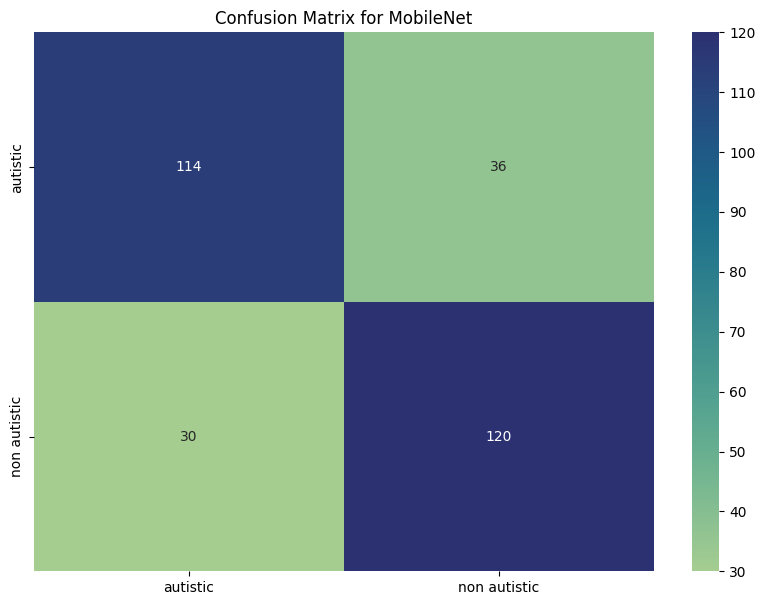

In [12]:
model_names = ['MobileNet']

for model_name in model_names:
    model = create_model(model_name)
    history = train_and_evaluate_model(model, train_data, val_data, test_data, model_name)

In [13]:

# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
#index_loss = np.argmin(val_loss)
#val_lowest = val_loss[index_loss]
#index_acc = np.argmax(val_acc)
#acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
#loss_label = f'best epoch= {str(index_loss + 1)}'
#acc_label = f'best epoch= {str(index_acc + 1)}'


In [14]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
#index_loss = np.argmin(val_loss)
#val_lowest = val_loss[index_loss]
#index_acc = np.argmax(val_acc)
#acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
#loss_label = f'best epoch= {str(index_loss + 1)}'
#acc_label = f'best epoch= {str(index_acc + 1)}'


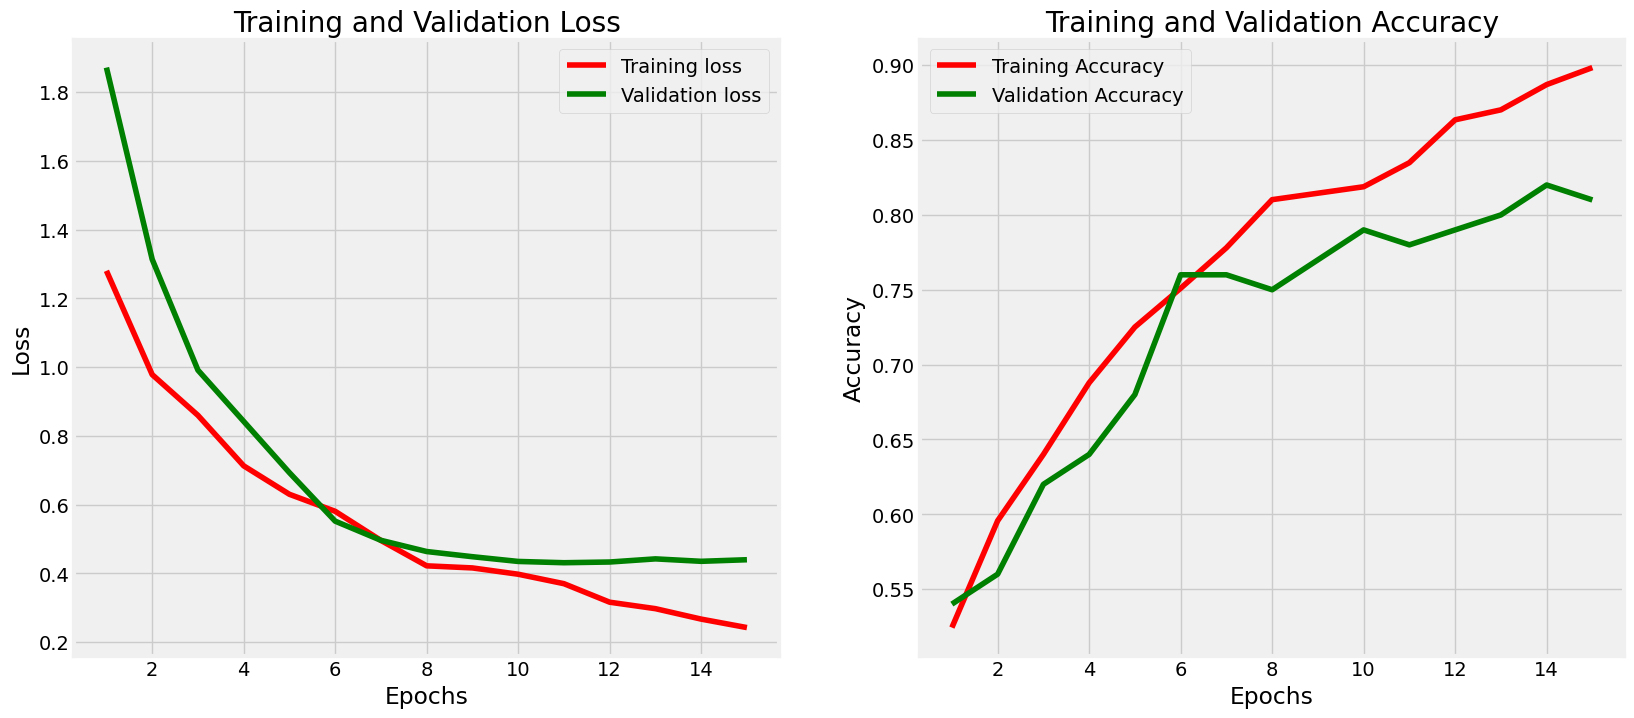

In [15]:
# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
#plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
#plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [16]:
model

In [17]:
#save model as h5
model.save('autism_v1.h5')

In [49]:
img_path = 'AutismDataset//test//non autistic//Non_Autistic.0.jpg'
img_path2 = 'AutismDataset//test//autistic//Autistic.0.jpg'

In [52]:
from PIL import Image

img = Image.open(img_path)
img2 = Image.open(img_path2)


In [34]:
resized_img = img.resize((224, 224))

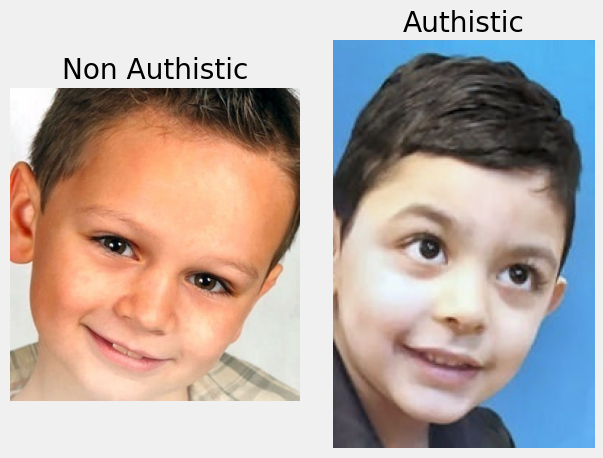

In [53]:
# Create a figure and two subplots (one for each image)
fig, (ax1, ax2) = plt.subplots(1, 2)  # One row, two columns

# Display original image
ax1.imshow(img)
ax1.set_title('Non Authistic')
ax1.axis('off')

# Display resized image
ax2.imshow(img2)
ax2.set_title('Authistic')
ax2.axis('off')

# Adjust layout to prevent overlapping elements
plt.tight_layout()

# Show the plot
plt.show()


In [62]:
def convert(img):
    # Resize image to match model input size
    img = img.resize((224, 224))
    # Add a new axis for batch dimension
    return np.array(img)[np.newaxis]

In [63]:
non_autism_img = convert(img)
autism_img = convert(img2)

In [64]:
#img_array[np.newaxis]
# Assuming you don't need to provide a target variable (y) for prediction
predictions = model.predict(autism_img)  


1/1 [==============================] - 0s 29ms/step


In [65]:
predictions

array([[0.9706293 , 0.02937078]], dtype=float32)

In [69]:
def make_prediction(img_path):
    img = Image.open(img_path)
    converted_img = convert(img)
    prediction = model.predict(converted_img)
    if prediction[0][0] > prediction[0][1]:
        return 'Autism'
    else:
        return 'Non-Autism'

In [71]:
img_path = 'AutismDataset//test//non autistic//Non_Autistic.8.jpg'
make_prediction(img_path)

1/1 [==============================] - 0s 215ms/step


'Non-Autism'